In [1]:
# copy the lib file in the working directory and load it
from shutil import copyfile
copyfile('target/release/libising_triangular.so', 'ising_triangular.so')
import ising_triangular as it

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import threading
import time

In [3]:
n = 75  # amount of temperatures / states
L = 32  # size of the lattice

# Initialize the states, compute the enegies and attribute their temperatures
xs = [np.random.randint(0, 2, size=(L, L), dtype=np.int32) * 2 - 1 for i in range(n)]
es = [it.energy(xs[i]) for i in range(n)]
ts = np.linspace(1.5, 5, n)

<IPython.core.display.Javascript object>


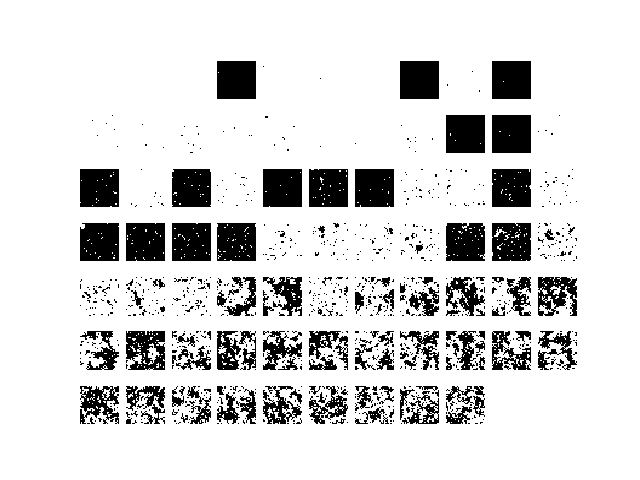

In [4]:
# This cell only makes a plot to show the evolutions of the states in real time

# compute the appropriate amount of plots to do in width
w = int(np.ceil(np.sqrt(1.5 * n)))

# create a new figure and its subplots
fig = plt.figure()
axes = [fig.add_subplot(int(np.ceil(n / w)), w, i + 1) for i in range(n)]

def plot(i):
    axes[i].set_axis_off()
    return axes[i].imshow(xs[i], cmap='gray', vmin=-1, vmax=1)

imgs = [plot(i) for i in range(n)]

fig.canvas.draw()

# this function sets the new data into the figure and redraw it
def replot(xs):
    for i in range(n):
        imgs[i].set_data(xs[i])
    fig.canvas.draw()

In [5]:
# for debug purpose, this function measure the execution time of a portion of code

def top(text=None):
    now = time.time()
    if text:
        print("{} : {:.3f}s".format(text, now - top.past))
    top.past = now
    
top.past = time.time()

In [12]:
# Define a function that perform sweep in parallel then do parallel tempering

def sweep_swap():
    num_threads = 4
    
    # create and run one thread for each temperature
    threads = []
    for i in range(num_threads):
        # define the function that will be run by the thread (it depends on the value of i)
        def sweep():
            # perform a sweep on the states i, i+num_threads, i+2*num_threads, ...
            for j in range(i, n, num_threads):
                es[j] += it.sweep(xs[j], ts[j]) # the sweep returns the delta in energy
        
        t = threading.Thread(target=sweep) # create a new thread
        t.start() # start it
        threads.append(t)

    # wait all threads to finish
    for t in threads:
        t.join()

    # performs swaps
    for _ in range(2 * n):
        [i, j] = np.random.choice(n, 2, replace=False) # pick randomly i != j
        if np.random.uniform() < np.exp((es[i] - es[j]) * (1 / ts[i] - 1 / ts[j])):
            # swap the states and the energies
            xs[i], xs[j] = xs[j], xs[i]
            es[i], es[j] = es[j], es[i]

In [13]:
top()
# thermalize
for _ in range(200):
    sweep_swap()

top('termalize')

m = 400
energy = np.zeros((m, n))
magnet = np.zeros((m, n))

for i in range(m):
    top()
    
    # Compute a Bin
    bs = 10 # amount of sweep_swap in the bin
    energy_bin = np.zeros(n)
    magnet_bin = np.zeros(n)
    
    for _ in range(bs):
        sweep_swap()
        energy_bin += np.array(es) / (L * L)
        magnet_bin += np.array([np.sum(xs[j]) for j in range(n)]) / (L * L)
    
    energy[i] = energy_bin / bs
    magnet[i] = magnet_bin / bs

    top(str(i) + ' compute bin')
    
    if i % 5 == 0:
        replot(xs)
        top('plot')

termalize : 2.056s
0 compute bin : 0.094s
plot : 0.130s
1 compute bin : 0.137s
2 compute bin : 0.180s
3 compute bin : 0.215s
4 compute bin : 0.185s
5 compute bin : 0.201s
plot : 0.298s
6 compute bin : 0.161s
7 compute bin : 0.209s
8 compute bin : 0.219s
9 compute bin : 0.220s
10 compute bin : 0.206s
plot : 0.295s
11 compute bin : 0.139s
12 compute bin : 0.118s
13 compute bin : 0.109s
14 compute bin : 0.111s
15 compute bin : 0.113s
plot : 0.135s
16 compute bin : 0.109s
17 compute bin : 0.111s
18 compute bin : 0.120s
19 compute bin : 0.120s
20 compute bin : 0.160s
plot : 0.327s
21 compute bin : 0.184s
22 compute bin : 0.136s
23 compute bin : 0.109s
24 compute bin : 0.110s
25 compute bin : 0.116s
plot : 0.138s
26 compute bin : 0.107s
27 compute bin : 0.105s
28 compute bin : 0.112s
29 compute bin : 0.109s
30 compute bin : 0.114s
plot : 0.139s
31 compute bin : 0.109s
32 compute bin : 0.106s
33 compute bin : 0.116s
34 compute bin : 0.102s
35 compute bin : 0.119s
plot : 0.140s
36 compute bin 

<IPython.core.display.Javascript object>


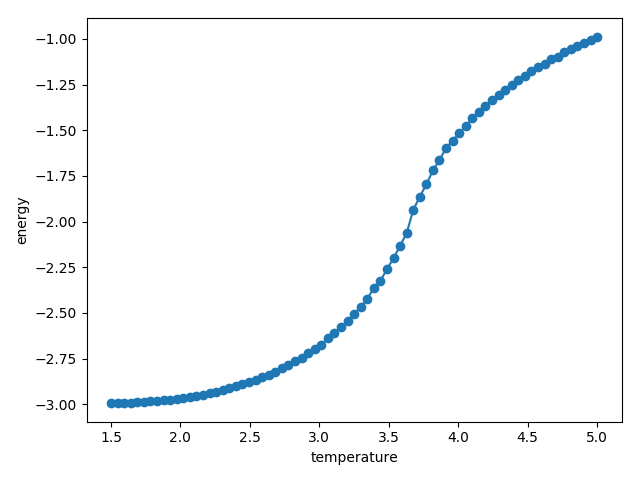

In [8]:
plt.figure()
plt.plot(ts, np.mean(energy, 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('energy')
plt.tight_layout()

<IPython.core.display.Javascript object>


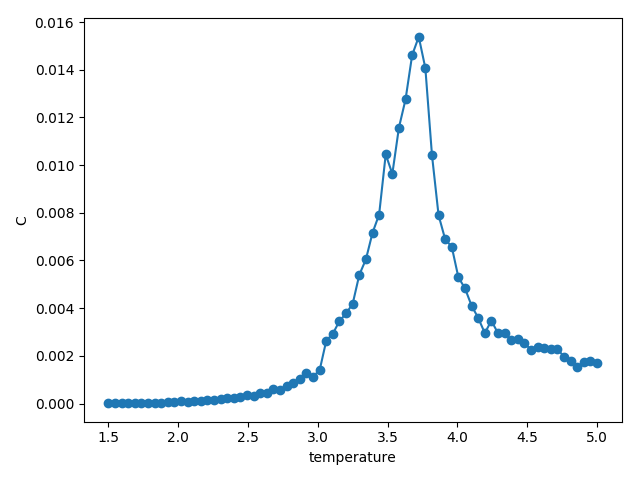

In [9]:
plt.figure()
plt.plot(ts, np.var(energy, 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('C')
plt.tight_layout()

<IPython.core.display.Javascript object>


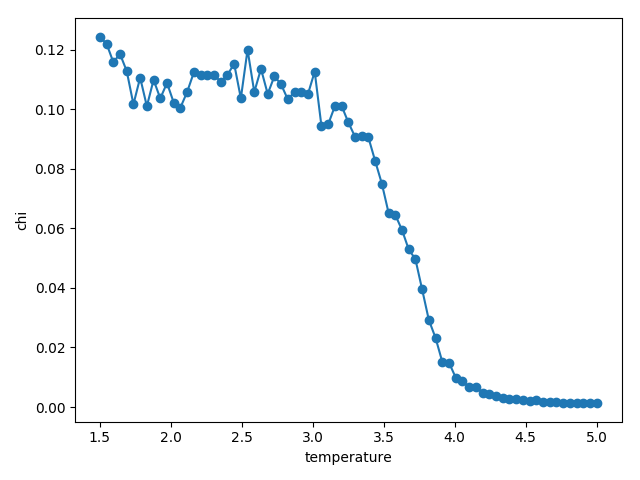

In [10]:
plt.figure()
plt.plot(ts, np.var(np.abs(magnet), 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('chi')
plt.tight_layout()

<IPython.core.display.Javascript object>


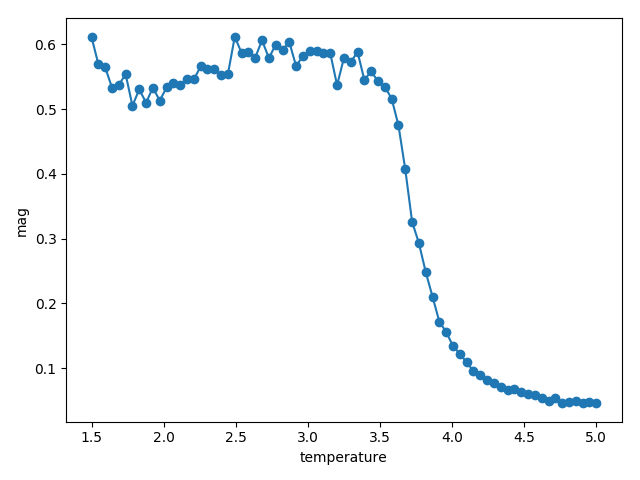

In [11]:
plt.figure()
plt.plot(ts, np.mean(np.abs(magnet), 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('mag')
plt.tight_layout()